# ENSF 544 Project 2 - CNN

In [267]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

training_dir = "dataset/asl_alphabet_train"
test_dir = "dataset/asl_alphabet_test"

In [268]:
import os.path
import cv2
import numpy as np

def load_data(directory):
    images = []
    labels = []

    # image size
    size = 32,32

    # Iterate through each image in each subfolder
    for folder in os.listdir(directory):
        for image in os.listdir(directory + "/" + folder):

            temp_img = cv2.imread(directory + '/' + folder + '/' + image)
            if temp_img is None:
                continue

            # Resize the images
            temp_img = cv2.resize(temp_img, size)
            # Run edge detection to isolate valuable sections of image
            temp_img = cv2.Canny(temp_img,100,200)
            
            images.append(temp_img)
            labels.append(folder)

    # Convert to a numpy array
    images = np.array(images)

    # Normalize the images
    images = images.astype('float32')/255.0
    
    return images, labels

In [258]:
from sklearn.model_selection import train_test_split

X_train, y_train = load_data(training_dir)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=0, test_size=0.2)

In [259]:
X_test, y_test = load_data(test_dir)

In [260]:
from tensorflow.keras.utils import to_categorical

classes = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

num_classes = len(classes)

y_train = list((map(lambda letter : classes.index(letter), y_train)))
y_valid = list((map(lambda letter : classes.index(letter), y_valid)))
y_test = list((map(lambda letter : classes.index(letter), y_test)))

y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

In [261]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(64, activation='sigmoid'))

model.add(layers.Dense(29, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 flatten_8 (Flatten)         (None, 4096)             

In [262]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [263]:
batch_size = 128
epochs = 15

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/15
544/544 [==============================] - 70s 125ms/step - loss: 1.8580 - accuracy: 0.5088 - val_loss: 0.8988 - val_accuracy: 0.7832
Epoch 2/15
544/544 [==============================] - 61s 112ms/step - loss: 0.7446 - accuracy: 0.8069 - val_loss: 0.4342 - val_accuracy: 0.8981
Epoch 3/15
544/544 [==============================] - 68s 124ms/step - loss: 0.4514 - accuracy: 0.8810 - val_loss: 0.2781 - val_accuracy: 0.9346
Epoch 4/15
544/544 [==============================] - 65s 119ms/step - loss: 0.3190 - accuracy: 0.9151 - val_loss: 0.1918 - val_accuracy: 0.9525
Epoch 5/15
544/544 [==============================] - 55s 101ms/step - loss: 0.2446 - accuracy: 0.9346 - val_loss: 0.1493 - val_accuracy: 0.9634
Epoch 6/15
544/544 [==============================] - 54s 99ms/step - loss: 0.2013 - accuracy: 0.9445 - val_loss: 0.1202 - val_accuracy: 0.9697
Epoch 7/15
544/544 [==============================] - 64s 117ms/step - loss: 0.1644 - accuracy: 0.9546 - val_loss: 0.1017 - val_acc

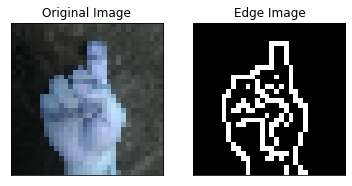

In [274]:
X_test, y_test = load_data(test_dir)
y_test = list((map(lambda letter : classes.index(letter), y_test)))
y_test = to_categorical(y_test, num_classes)

temp_img = cv2.imread(test_dir + '/' + 'X' + '/' + 'X_ET1.jpg')
temp_img = cv2.resize(temp_img, (32,32))

edges = cv2.Canny(temp_img,100,200)
# edges = cv2.resize(edges, (32,32))

plt.subplot(121),plt.imshow(temp_img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [271]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.8448275923728943


In [272]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 8ms/step


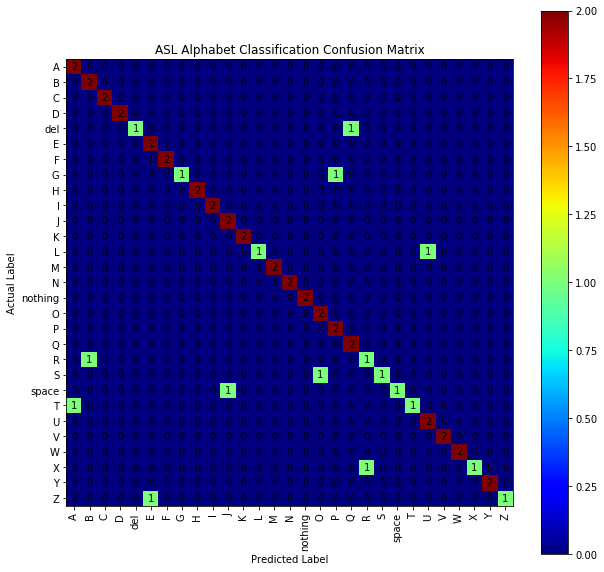

In [273]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(cm), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = cm.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), classes[:width], rotation=90)
plt.yticks(range(height), classes[:height])
plt.title('ASL Alphabet Classification Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig('confusion_matrix.png', format='png')